In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using MCMCDiagnostics
using CSV
using Printf

In [2]:
#include("../../../util2.j")

In [3]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
#using Pkg
#Pkg.add("ProgressMeter");

In [5]:
@load "../data/sim3data.jld";

┌ Warning: type Main.#BuildNN does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1061
┌ Warning: type Main.#colnorm does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1061
┌ Warning: type Main.#getAD does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1061
┌ Warning: type Main.#getAD_collapse does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1061
┌ Warning: type Main.#kfoldperm does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1061


In [6]:
# 
p = 3;
N_sam = 10000;
N_pre_burn = Integer(trunc(0.5 * N_sam));
half_sample = Integer((N_sam - N_pre_burn) / 2);
N_sim = 1;
N_K = 10;

In [7]:
#Rhat ESS
ESS_slope = fill(0.0, (p - 1), q, N_K, N_sim);
MCSE_slope = fill(0.0, (p - 1), q, N_K, N_sim);
Rhat_slope = fill(0.0, (p - 1), q, N_K, N_sim);
ESS_ω_cov = fill(0.0, q, q, N_K, N_sim);
MCSE_ω_cov = fill(0.0, q, q, N_K, N_sim);
Rhat_ω_cov = fill(0.0, q, q, N_K, N_sim);
ESS_ω_corr = fill(0.0, q, q, N_K, N_sim);
MCSE_ω_corr = fill(0.0, q, q, N_K, N_sim);
Rhat_ω_corr = fill(0.0, q, q, N_K, N_sim);
ESS_Σ = fill(0.0, q, N_K, N_sim);
MCSE_Σ = fill(0.0, q, N_K, N_sim);
Rhat_Σ = fill(0.0, q, N_K, N_sim);

#counts
count_slope = fill(0, N_K, N_sim);
count_ω_incp = fill(0.0, q, N_K, N_sim);
count_Y_M = fill(0.0, q, N_K, N_sim);

RMSPE = fill(0.0, N_K, N_sim);

In [8]:
prog = Progress(N_sim, 1, "Computing initial pass...", 50)
for ind in 1:N_sim
    for K in 1:10
        print(ind, "th simulation with K = ", K, "\n");
        γ_sam = convert(Matrix{Float64}, 
            CSV.read(@sprintf("../results/K%01.d/γ_sam.csv", K)));
        ind_γ_sam = 1: (p + K) :((p + K) * N_sam + 1);
        Σ_sam = convert(Matrix{Float64}, 
            CSV.read(@sprintf("../results/K%01.d/Σ_sam.csv", K)));
        ind_Σ_sam = 1: q :(q * N_sam + 1);
        ω_cov_sam = convert(Matrix{Float64}, 
            CSV.read(@sprintf("../results/K%01.d/ω_cov_sam.csv", K)));
        ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);
        saved_output=jldopen(@sprintf("../results/K%01.d/Factor_mean_var_K%01.d.jld", K, K));
        ω_incp_sam_mean = saved_output["ω_incp_sam_mean"];
        ω_incp_sam_var = saved_output["ω_incp_sam_var"];
        Y_m_sam_mean = saved_output["Y_m_sam_mean"];
        Y_m_sam_var = saved_output["Y_m_sam_var"];
            
        covω = cov(ω_ord[S, :]);
        corω = cor(ω_ord[S, :]);
        ω_cov_pos_sam_mean = [mean(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) 
        for i in 1:q, j in 1:q];
        ω_corr_sam = [(Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q]) * 
            ω_cov_sam[ind_ω_cov_sam[l] .+ (1:q) .- 1, 1:q] * 
                Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q])) for l in 1:N_sam];
        ω_corr_sam_mean = [mean([ω_corr_sam[i][j , k] for i in (N_pre_burn + 1):N_sam]) 
            for j in 1:q, k in 1:q];

        # ESS-slope #
        for i in 2:p
            for j in 1:q
                ESS_slope[i - 1, j, K, ind] = 
                    effective_sample_size(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]);
                MCSE_slope[i - 1, j, K, ind] = std(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)]) / 
                    sqrt(ESS_slope[i - 1, j, K, ind]);
                Rhat_slope[i - 1, j, K, ind] = potential_scale_reduction(
                    γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
                    γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam])
            end
        end
        print("slope ESS&MCSE:", [minimum(ESS_slope[:, :, K, ind]), 
                maximum(Rhat_slope[:, :, K, ind])], "\n")
        
        for j in 1:q
            for i in 1:q
                ESS_ω_cov[i, j, K, ind] = 
                    effective_sample_size(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]);
                MCSE_ω_cov[i, j, K, ind] = std(ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):N_sam]) / 
                    sqrt(ESS_ω_cov[i, j, K, ind]);
                Rhat_ω_cov[i, j, K, ind] = potential_scale_reduction(
                    ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
                    ω_cov_sam[ind_ω_cov_sam .+ (i - 1), j][(N_pre_burn + half_sample + 1):N_sam]);
            end
        end
        print("ω_cov ESS&MCSE:", [minimum(ESS_ω_cov[:, :, K, ind]), 
                maximum(Rhat_ω_cov[:, :, K, ind])], "\n")
        
        for j in 1:q
            for i in 1:q
                ESS_ω_corr[i, j, K, ind] = 
                    effective_sample_size([ω_corr_sam[k][i, j] for k in (N_pre_burn + 1):N_sam]);
                MCSE_ω_corr[i, j, K, ind] = std([ω_corr_sam[k][i, j] for k in (N_pre_burn + 1):N_sam]) / 
                    sqrt(ESS_ω_corr[i, j, K, ind]);
                Rhat_ω_corr[i, j, K, ind] = potential_scale_reduction(
                    [ω_corr_sam[k][i, j] for k in (N_pre_burn + 1):(N_pre_burn + half_sample)], 
                    [ω_corr_sam[k][i, j] for k in (N_pre_burn + 1):N_sam]);
            end
        end
        print("ω_corr ESS&MCSE:",[minimum(ESS_ω_corr[:, :, K, ind]), 
                maximum(Rhat_ω_corr[:, :, K, ind])], "\n")
        
        for i in 1:q
            ESS_Σ[i, K, ind] = 
                effective_sample_size(Σ_sam[ind_Σ_sam .+ (i - 1)][(N_pre_burn + 1):N_sam]);
            MCSE_Σ[i, K, ind] = std(Σ_sam[ind_Σ_sam .+ (i - 1)][(N_pre_burn + 1):N_sam]) / 
                sqrt(ESS_Σ[i, K, ind]);
            Rhat_Σ[i, K, ind] = potential_scale_reduction(
                Σ_sam[ind_Σ_sam .+ (i - 1)][(N_pre_burn + 1):(N_pre_burn + half_sample)], 
                Σ_sam[ind_Σ_sam .+ (i - 1)][(N_pre_burn + half_sample + 1):N_sam]);
        end
        print("Σ ESS&MCSE:", [minimum(ESS_Σ[:, K, ind]), maximum(Rhat_Σ[:, K, ind])], "\n")
            
        # CVG-slope #
        for i in 2:p
            for j in 1:q
                if ((quantile(γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)], [0.025])[1] < 
                        β[i, j] ) && (quantile(
                                γ_sam[ind_γ_sam .+ (i - 1), j][(N_pre_burn + 1):(N_sam + 1)], [0.975])[1] > 
                        β[i, j] ))
                    count_slope[K, ind] = count_slope[K, ind] + 1.0;
                end    
            end
        end
        print("count_slope:", count_slope[K, ind], "\n")
        
        # CVL #
        for j in 1:q
            for i in 1:Nobs
                count_ω_incp[j, K, ind] = count_ω_incp[j, K, ind] + 
                (((ω_incp_sam_mean[i, j] - 1.96 * sqrt(ω_incp_sam_var[i, j])) < ω_incp_obs[S[i], j]) && 
                    ((ω_incp_sam_mean[i, j] + 1.96 * sqrt(ω_incp_sam_var[i, j])) > ω_incp_obs[S[i], j]))
            end
        end
        print("count_ω_incp", round.(count_ω_incp[:, K, ind] ./ Nobs, digits = 5), 
            sum(count_ω_incp[:, K, ind]) / (q*Nobs), "\n")    
            
        # CVG #
        #Y_m_pos_qt = [Array{Float64, 2}(undef, length(M_ind[ind]), 3) for ind in 1:q];
        for i in 1:q
            for j in 1:length(M_ind[i])
                count_Y_M[i, K, ind] = count_Y_M[i, K, ind] + (((Y_m_sam_mean[i][j] - 
                    1.96 * sqrt(Y_m_sam_var[i][j])) < Y_ord[M_ind[i][j], i]) && 
                     ((Y_m_sam_mean[i][j] + 1.96 * sqrt(Y_m_sam_var[i][j])) > 
                    Y_ord[M_ind[i][j], i]))
            end
        end
        print("count_Y_M: ", round.(count_Y_M[:, K, ind] ./ 200, digits = 4), 
                round.(mean(count_Y_M[:, K, ind] ./ 200), digits = 4), "\n");
        
        # RMSPE #
        MSPE = (sum([sum((Y_m_sam_mean[i] - Y_ord[S[M_Sind[i]], i]).^2) for i in 1:q])) / 
            (sum([length(M_Sind[i]) for i in 1:q]))
        RMSPE[K, ind] = sqrt(MSPE); 
        print("RMSPE:", round.([sqrt((sum((Y_m_sam_mean[i] - Y_ord[S[M_Sind[i]], i]).^2)) / 
            length(M_Sind[i])) for i in 1:q], digits = 4), round(RMSPE[K, ind], digits = 4), "\n");
        
        print("Minimum MCSE:", round(minimum([minimum(ESS_slope[:, :, K, ind]), minimum(ESS_Σ[:, K, ind]), 
                    minimum(ESS_ω_cov[:, :, K, ind])]), digits = 3), "\n")
        print("Maximum MCSE:", round(maximum([maximum(MCSE_slope[:, :, K, ind]), maximum(MCSE_Σ[:, K, ind]), 
                    maximum(MCSE_ω_cov[:, :, K, ind])]), digits = 3), "\n")
        print("Maximum Rhat:", round(maximum([maximum(Rhat_slope[:, :, K, ind]), maximum(Rhat_Σ[:, K, ind]), 
                    maximum(Rhat_ω_cov[:, :, K, ind])]), digits = 3), "\n")
    end
    next!(prog)
end

1th simulation with K = 1
slope ESS&MCSE:[2001.4311550906884, 1.0009826885720408]
ω_cov ESS&MCSE:[563.3400872784849, 1.0033621598710767]
ω_corr ESS&MCSE:[4093.2570328919064, 1.0000148402348108]
Σ ESS&MCSE:[340.76159894455037, 1.0019090635467274]
count_slope:18
count_ω_incp[0.155, 0.184, 0.371, 0.188, 0.179, 0.359, 0.226, 0.364, 0.238, 0.837]0.3101
count_Y_M: [0.955, 0.94, 0.975, 0.94, 0.93, 0.945, 0.96, 0.935, 0.96, 0.97]0.951
RMSPE:[1.8318, 2.0764, 1.6455, 2.5856, 2.0944, 2.126, 2.1893, 1.6641, 2.089, 1.129]1.9791
Minimum MCSE:340.762
Maximum MCSE:0.007
Maximum Rhat:1.003
1th simulation with K = 2
slope ESS&MCSE:[1471.1361170350954, 1.0018556334746387]
ω_cov ESS&MCSE:[438.82367981783995, 1.002383321652159]
ω_corr ESS&MCSE:[1653.6880744769358, 1.00048484864708]
Σ ESS&MCSE:[230.80155460835337, 1.002496510989342]
count_slope:17
count_ω_incp[0.266, 0.201, 0.403, 0.206, 0.925, 0.359, 0.231, 0.38, 0.254, 0.782]0.4007
count_Y_M: [0.915, 0.945, 0.975, 0.93, 0.94, 0.94, 0.955, 0.93, 0.95, 0.96

In [9]:
using RCall
for K in 1:N_K
    ω_cov_sam = convert(Matrix{Float64}, 
            CSV.read(@sprintf("../results/K%01.d/ω_cov_sam.csv", K)));
    ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);
    ω_corr_sam = [(Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q]) * 
        ω_cov_sam[ind_ω_cov_sam[l] .+ (1:q) .- 1, 1:q] * 
        Diagonal([1 / sqrt(ω_cov_sam[ind_ω_cov_sam[l] .+ (i - 1), i]) for i in 1:q])) for l in 1:N_sam];
    ω_corr_sam_mean = [mean([ω_corr_sam[i][j , k] for i in (N_pre_burn + 1):N_sam]) 
        for j in 1:q, k in 1:q] 
    @rput ω_corr_sam_mean
    @rput K
    R"""
    library(corrplot)
    library(corrgram)
    
    colnames(ω_corr_sam_mean) <- c(1:10)
    rownames(ω_corr_sam_mean) <- c(1:10)

    width <- 720
    height <- 720
    pointsize <- 16


    png(paste("../pics/sim3_factor_corr_K", K, "_plot.png", sep = ""), 
        width = width, height = height, pointsize = pointsize, family = "Courier")
    par(mfrow = c(1, 1))
    #corrplot(ω_corr_sam_mean, method="number", type = "upper", diag = FALSE, 
    #         addshade = "negative", number.digits = 2, tl.pos = "td")

    corrgram(ω_corr_sam_mean, order=FALSE, lower.panel=panel.shade, gap = 0.2,
         upper.panel=panel.pie, text.panel=panel.txt, main=" ",
         col.regions = colorRampPalette(c( "darkseagreen3",
                                           "white", "cadetblue3")))
    dev.off()
    """
end

┌ Warning: RCall.jl: corrplot 0.84 loaded
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: Registered S3 method overwritten by 'seriation':
│   method         from 
│   reorder.hclust gclus
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113


# MCMC Chain check

In [10]:
K = 9
p = size(X_ord)[2]; q = size(Y_ord)[2];
N_sam = 10000;
N_pre_burn = Integer(trunc(0.5 * N_sam));
N_pre_adapt = Integer(trunc(0.25 * N_sam));
N_after_burn = N_sam - N_pre_burn;
N_pre_burn = Integer(trunc(0.25 * N_sam));
γ_sam = convert(Matrix{Float64}, 
    CSV.read(@sprintf("../results/K%01.d/γ_sam.csv", K)));
ind_γ_sam = 1: (p + K) :((p + K) * N_sam + 1);
Σ_sam = convert(Matrix{Float64}, 
    CSV.read(@sprintf("../results/K%01.d/Σ_sam.csv", K)));
ind_Σ_sam = 1: q :(q * N_sam + 1);
ω_cov_sam = convert(Matrix{Float64}, 
    CSV.read(@sprintf("../results/K%01.d/ω_cov_sam.csv", K)));
ind_ω_cov_sam = 1: q :(q * (N_sam - 1) + 1);
saved_output=jldopen(@sprintf("../results/K%01.d/Factor_mean_var_K%01.d.jld", K, K));
ω_incp_sam_mean = saved_output["ω_incp_sam_mean"];
ω_incp_sam_var = saved_output["ω_incp_sam_var"];
Y_m_sam_var = saved_output["Y_m_sam_var"];

In [11]:
Rhat_Σ[:, 9, 1]

10-element Array{Float64,1}:
 1.002747730212869 
 1.0002313396011961
 1.0049301305949199
 1.0007232173930047
 1.0020360641888033
 1.0174569826772397
 1.01760839954972  
 1.0001712790777957
 1.0051178247150796
 1.045790660495345 

In [12]:
ESS_Σ[:, 9, 1]

10-element Array{Float64,1}:
 108.81951248371836
 256.9602645303916 
 156.03031254228836
 270.0553972425819 
 306.54767086140964
 595.3646807053759 
 321.1447598245889 
 103.60370672083889
 295.8801426465337 
  66.91928810008183

In [13]:
using StatsPlots
using MCMCChains

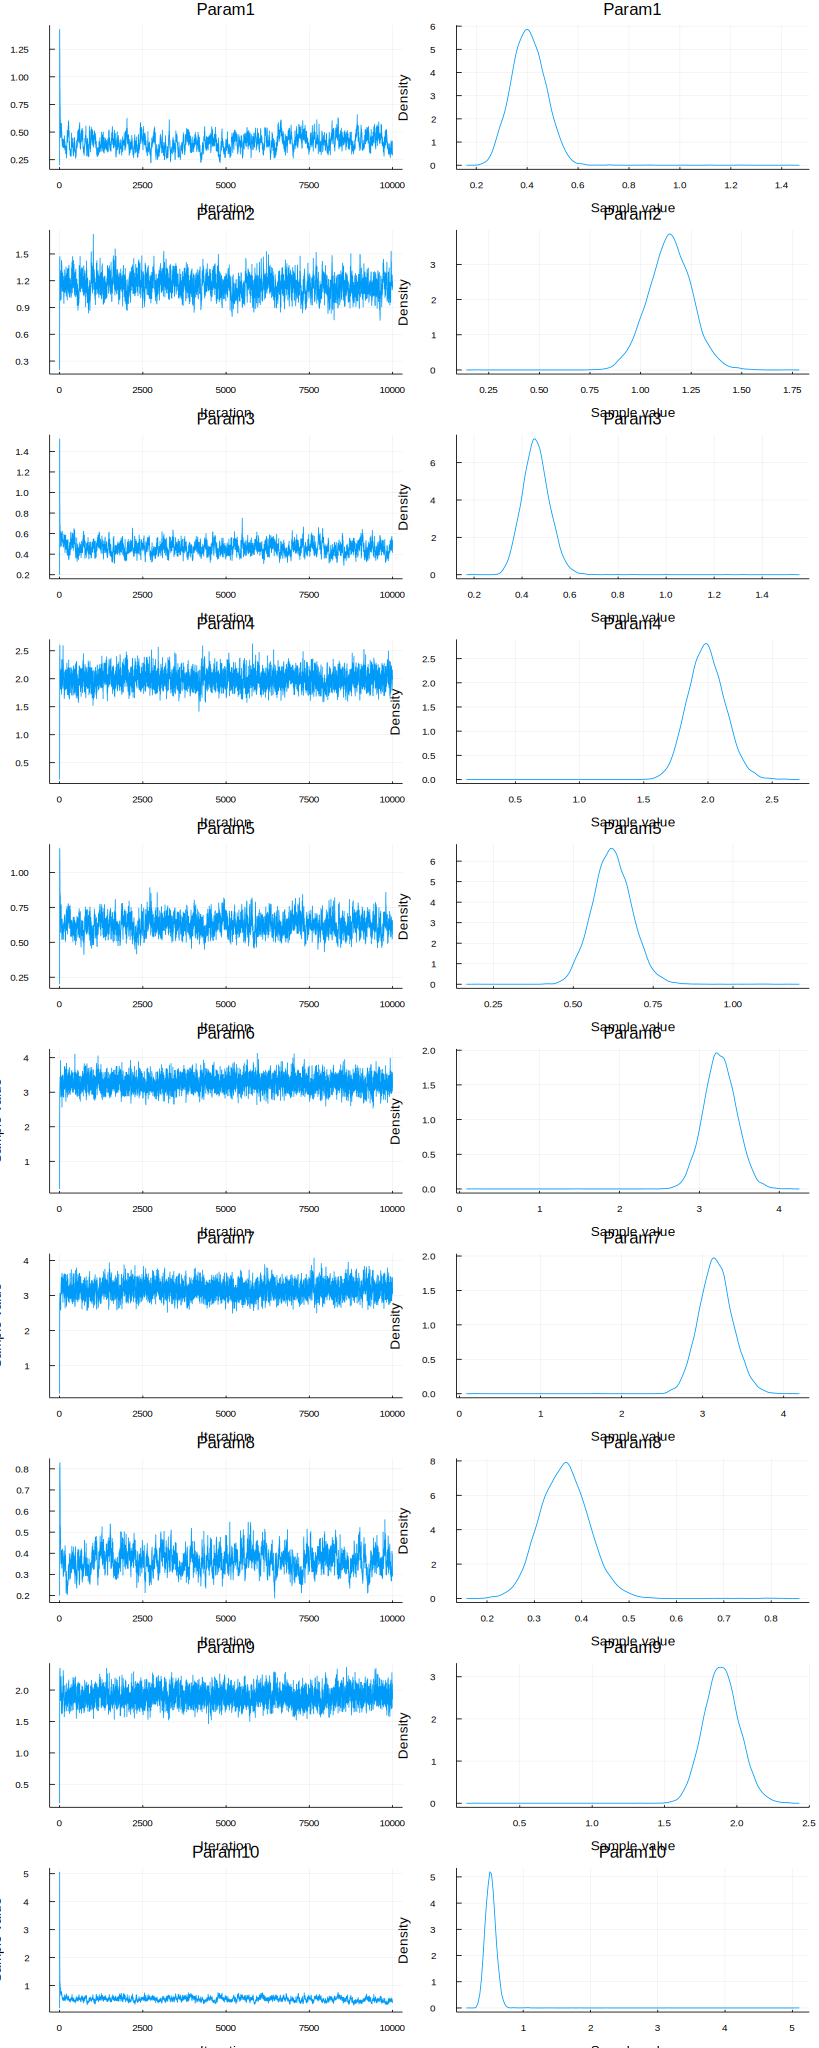

In [14]:
Σ_pos_sam = Array{Float64, 3}(undef, N_sam + 1, q, 1);
Σ_pos_sam[:, :, 1] = hcat([Σ_sam[ind_Σ_sam .+ (ind - 1)] for ind in 1:q]...);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)